# Evaluation of models
The purpose of this notebook is to evaluate classification models trained with one dataset to be tested on all datasets of the same type. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Reconstruct import reconstruction_cnn
from Classify import classification_cnn
import confusion_matrix as cm

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [4]:
%%time
SNR = "noiseless" #'30dB' #noise level in decibels dB
method = "direct"
model = None
# Define model parameters
params = {
  "dataset": f"MNIST_mura_{SNR}", # for testing purposes, always start with noiseless data
  # "learning_rate": 1e-3,
  # "batch_size": 100,
  "p": 23, # size of array (has to be prime)
  "image_size": 23,
  "kind": "classification",
  "suffix": f"{SNR}",
  "SNR": SNR,
  "method": method,
}

# Determine which device is being used
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define model with given params
model = classification_cnn(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) 

# Load trained model
print("Loading model: ", model.params['model_save_path'])
model.load_state_dict(torch.load(model.params['model_save_path']))

Loading model:  ../models/classification/MNIST/classification_noiseless.pth
CPU times: user 6.45 ms, sys: 5.45 ms, total: 11.9 ms
Wall time: 31.3 ms


<All keys matched successfully>

In [6]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(train_data[idx][0].squeeze(), cmap='gray')
    plt.title(f'Label: {train_data[idx][1]}')
    # plt.subplot(2, 5, count + 6)
    # sns.heatmap(train_data[idx][1].squeeze(), cmap='gray')
    # plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

NameError: name 'train_data' is not defined

In [6]:
%%time
# Initialize model dictionaries for data
train_data_dict = {}
eval_data_dict = {}
test_data_dict = {}
loader_dict = {}

# Get Noiseless data first
print(f"Loading noiseless data")
train_data_dict[f'train_data_noiseless'], \
eval_data_dict[f'eval_data_noiseless'], \
test_data_dict[f'eval_data_noiseless'], \
loader_dict[f'loaders_noiseless'] = classification_cnn.load_encoded_data(model.params)

# Now get dataset for each SNR
for SNR in [1,5,10,20,30]:
    print(f"Loading data for SNR = {SNR}dB")
    # Change dataset name to noisy dataset
    model.params['dataset'] = f"MNIST_mura_{SNR}dB"
    
    # Load data
    train_data_dict[f'train_data_{SNR}dB'], \
    eval_data_dict[f'eval_data_{SNR}dB'], \
    test_data_dict[f'test_data_{SNR}dB'], \
    loader_dict[f'loaders_{SNR}dB'] = classification_cnn.load_encoded_data(model.params)

#train_data, eval_data, test_data, loaders = classification_cnn.load_encoded_data(params)

Loading noiseless data
Loading dataset from: ../data/MNIST/training_MNIST_mura_noiseless
Loading data for SNR = 1dB
Loading dataset from: ../data/MNIST/training_MNIST_mura_1dB
Loading data for SNR = 5dB
Loading dataset from: ../data/MNIST/training_MNIST_mura_5dB
Loading data for SNR = 10dB
Loading dataset from: ../data/MNIST/training_MNIST_mura_10dB
Loading data for SNR = 20dB
Loading dataset from: ../data/MNIST/training_MNIST_mura_20dB
Loading data for SNR = 30dB
Loading dataset from: ../data/MNIST/training_MNIST_mura_30dB
CPU times: user 35.8 s, sys: 16 s, total: 51.8 s
Wall time: 1min 38s


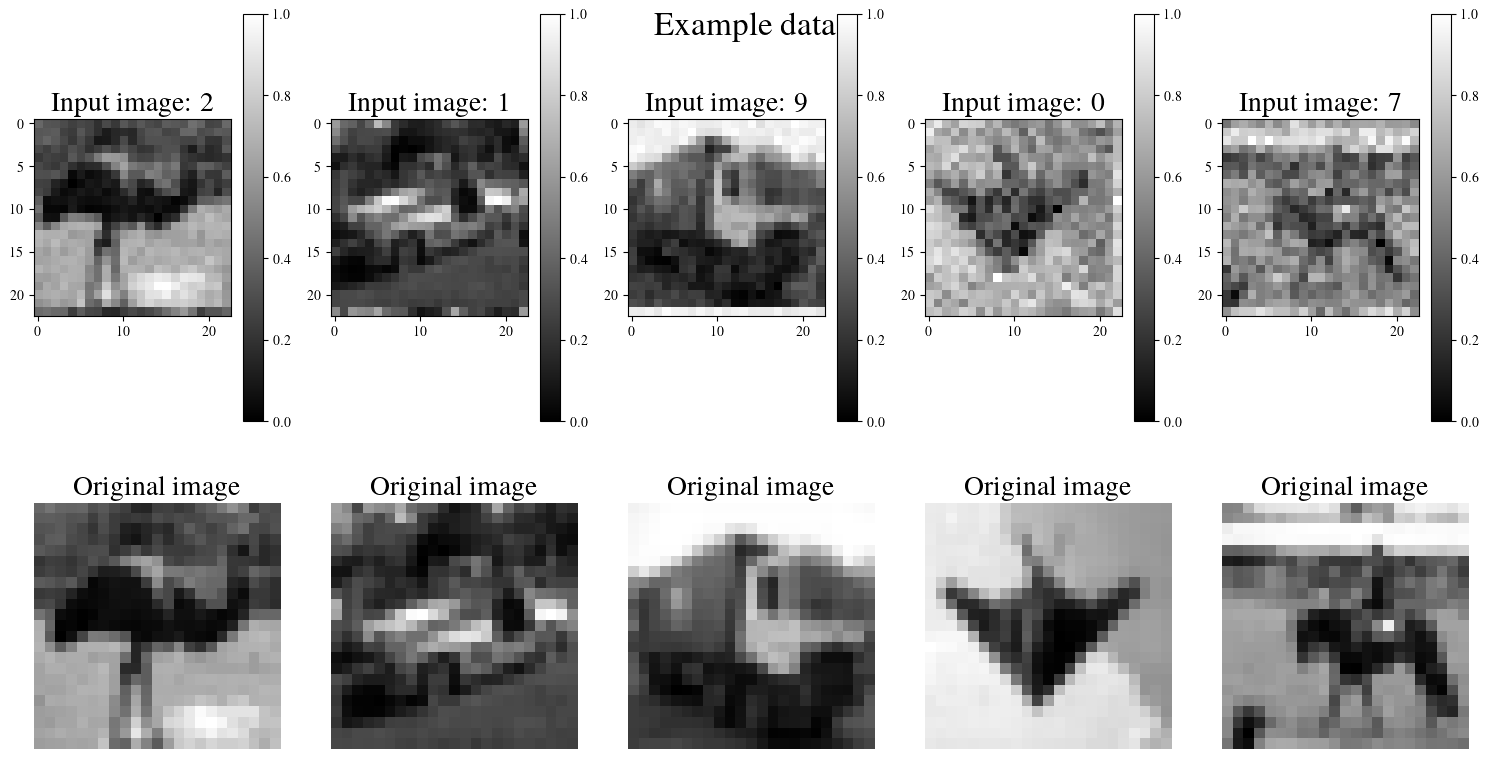

In [6]:
# Update plotting parameters
plt.rcParams.update({
    "figure.figsize" : [15,8.5],
})
label_size = 20
title_size = 24
# Printing 25 random images from the training dataset
train_data = []
for SNR in [1,5,10,20,30]:
    train_data = train_data + train_data_dict[f'train_data_{SNR}dB']
random_samples = np.random.randint(1, len(train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    plt.imshow(train_data[idx][0][0].numpy(), cmap='gray')
    plt.colorbar()
    plt.title(f'Input image: {train_data[idx][2]}', fontsize = label_size)
    plt.subplot(2, 5, count + 6)
    plt.imshow(train_data[idx][1][0].numpy(), cmap='gray')
    plt.title('Original image', fontsize = label_size)
    plt.axis('off')
    
    count += 1
plt.tight_layout()
plt.suptitle(f"Example data", fontsize=title_size)
#plt.savefig(f"../figs/examples_{SNR}db_data.png")
plt.show()

# Evaluation of model on evaluation/test set

In [7]:
results = {}
print("Using model: ", model.params['model_save_path'])

# Print out accuracy for each dataset using the model loaded
# Evaluate model accuracy for noisy data
for SNR in [1,5,10,20,30]:
    
    print(f"Getting results for SNR = {SNR}dB")
    results[f'predicted_{SNR}dB'], \
    results[f'labels_{SNR}dB'], \
    results[f'incorrect_examples_{SNR}dB'] = model.evaluate_model(model,loader_dict[f'loaders_{SNR}dB'])
    
# Evaluate model accuracy for noiseless data
print(f"Getting results for Noiseless")
results[f'predicted_noiseless'], \
results[f'labels_noiseless'], \
results[f'incorrect_examples_noiseless'] = model.evaluate_model(model,loader_dict[f'loaders_noiseless'])    

Using model:  ../models/classification/MNIST/classification_noiseless.pth
Getting results for SNR = 1dB
Accuracy: 82.729 %
Getting results for SNR = 5dB
Accuracy: 93.814 %
Getting results for SNR = 10dB
Accuracy: 96.529 %
Getting results for SNR = 20dB
Accuracy: 97.471 %
Getting results for SNR = 30dB
Accuracy: 97.529 %
Getting results for Noiseless
Accuracy: 97.529 %


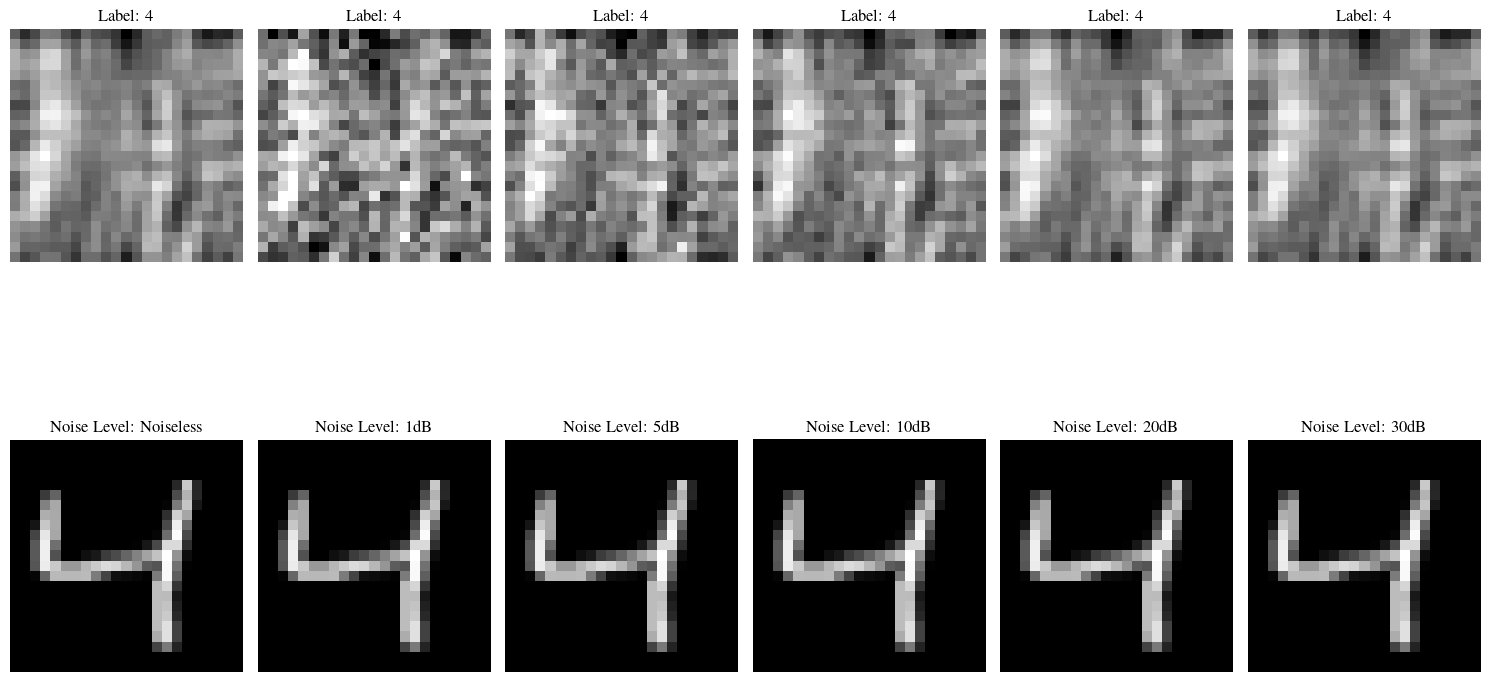

In [30]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_data_dict[f'train_data_noiseless']), (5))
count = 0

for idx in [2]: 
    
    for key in train_data_dict.keys():
        plt.subplot(2, 6, count + 1)
        plt.imshow(train_data_dict[key][idx][0].squeeze(), cmap='gray')
        plt.title(f"Label: {train_data_dict[key][idx][2]}")
        plt.axis("off")
        
        plt.subplot(2, 6, count + 7)
        plt.imshow(train_data_dict[key][idx][1].squeeze(), cmap='gray')
        if "noiseless" in key:
            plt.title('Noise Level: Noiseless')
        else:
            plt.title(f'Noise Level: {train_data_dict[key][idx][3]}')
        plt.axis('off')
        count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

In [22]:
train_data_dict.keys()

dict_keys(['train_data_noiseless', 'train_data_1dB', 'train_data_5dB', 'train_data_10dB', 'train_data_20dB', 'train_data_30dB'])

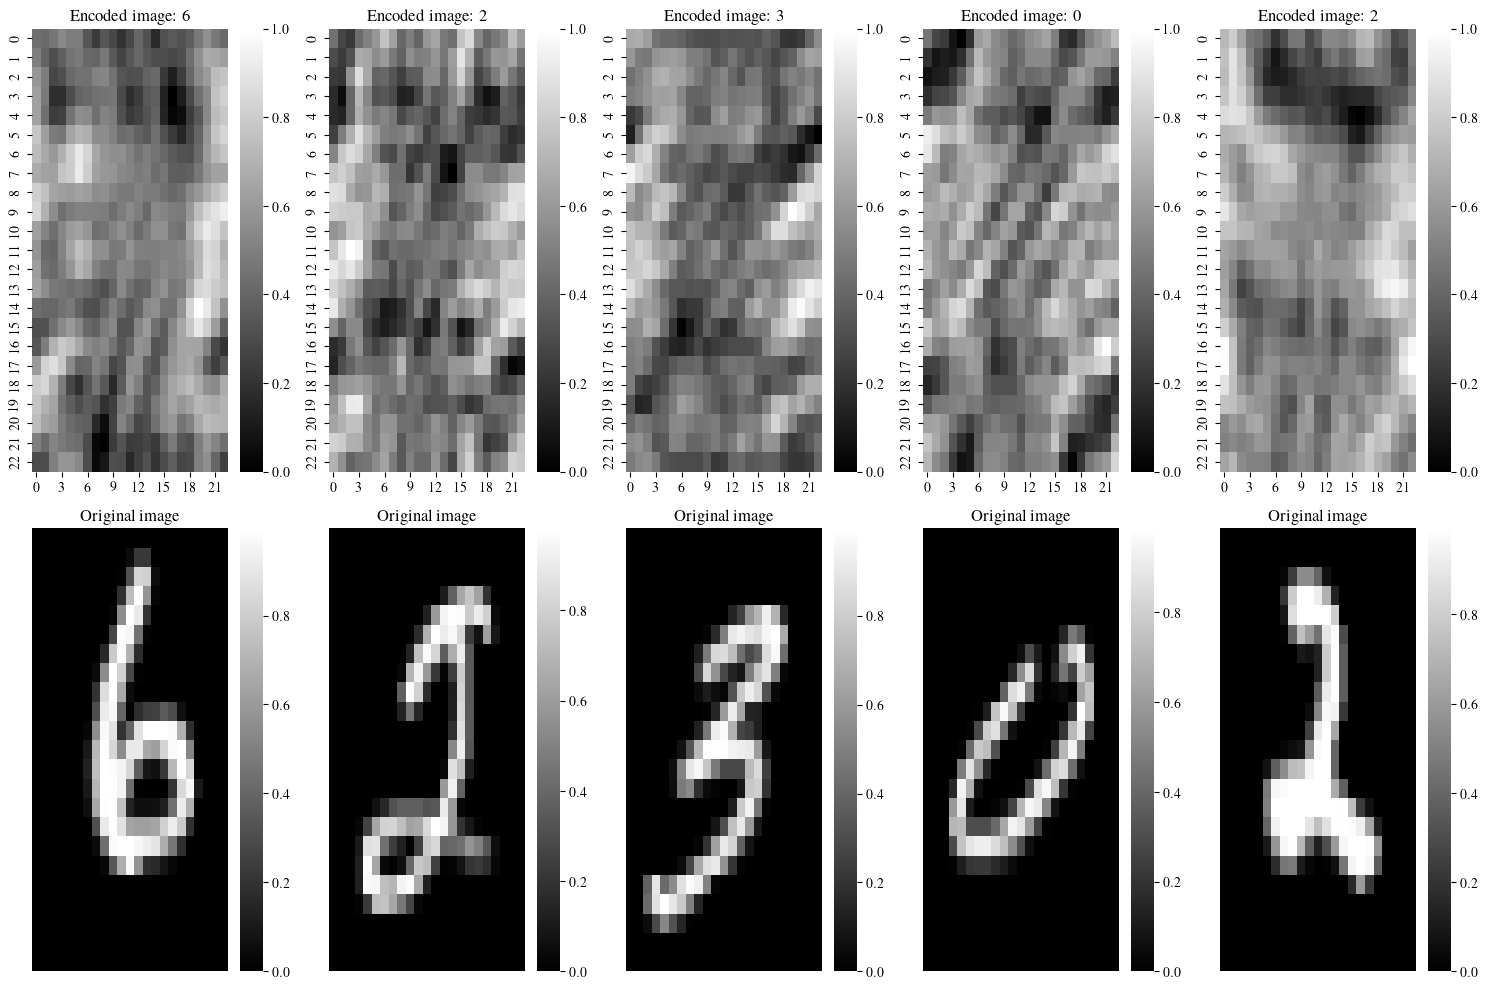

In [13]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_data_dict[f'train_data_noiseless']), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(train_data_dict[f'train_data_noiseless'][idx][0].squeeze(), cmap='gray')
    plt.title(f"Encoded image: {train_data_dict[f'train_data_noiseless'][idx][2]}")
    plt.subplot(2, 5, count + 6)
    sns.heatmap(train_data_dict[f'train_data_noiseless'][idx][1].squeeze(), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

## Confusion Matrix

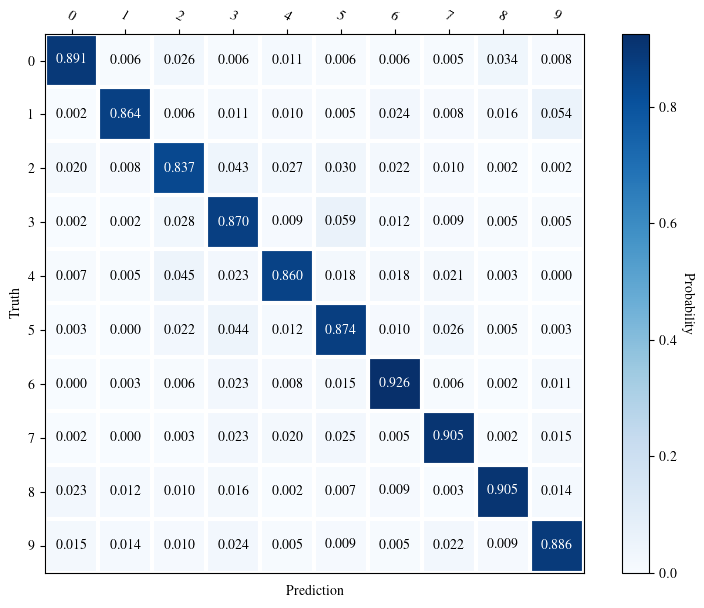

In [17]:
import sklearn
## Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in predicted_all]
truths = [tru for tru in labels_all]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
#fig1.savefig("../figs/conf_mat.png")

## Class-specific accuracy

In [53]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        if len(data) == 3:
            images, _, labels = data
        elif len(data) == 4:
            # get images and labels from test set
            _, _, images, labels = data
        else: raise Exception("Make sure you are loading the correct data")
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.3f} %')

Accuracy for class:     0 is 98.872 %
Accuracy for class:     1 is 99.245 %
Accuracy for class:     2 is 96.523 %
Accuracy for class:     3 is 97.262 %
Accuracy for class:     4 is 96.687 %
Accuracy for class:     5 is 97.209 %
Accuracy for class:     6 is 98.688 %
Accuracy for class:     7 is 96.814 %
Accuracy for class:     8 is 97.529 %
Accuracy for class:     9 is 96.218 %


# Missclassifications

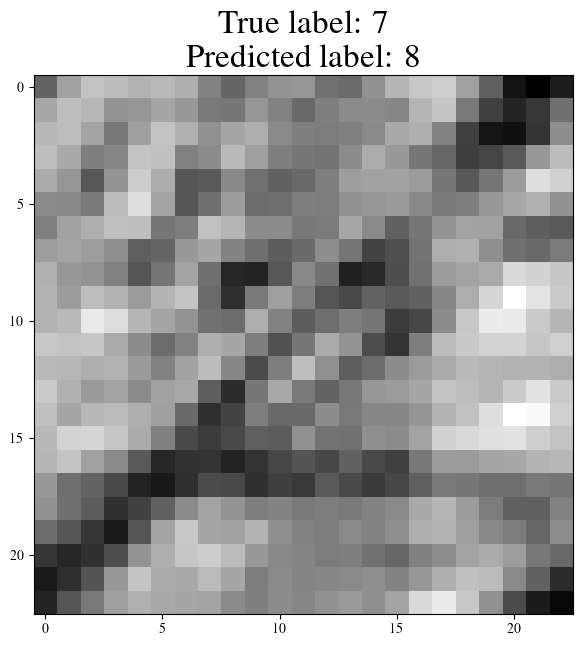

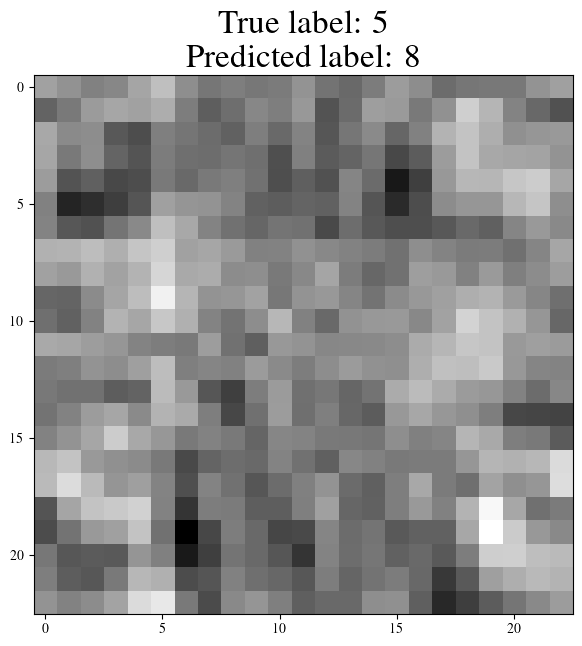

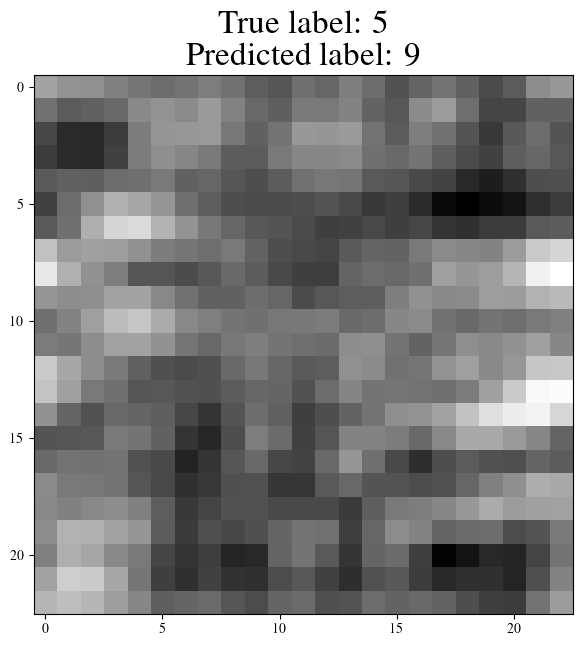

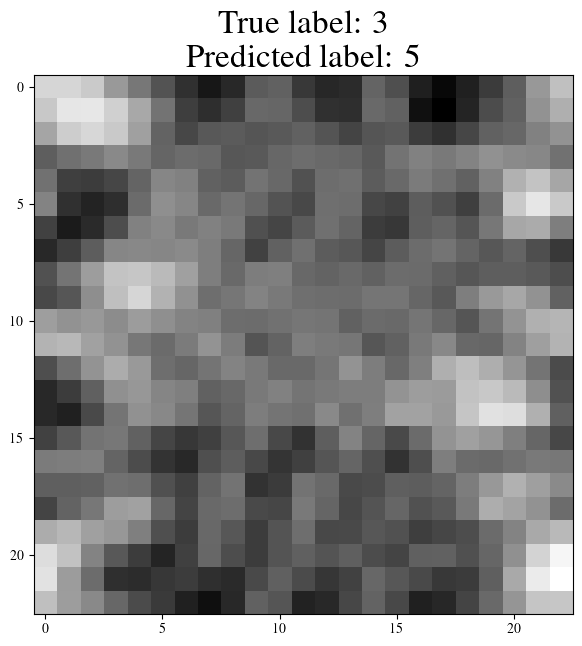

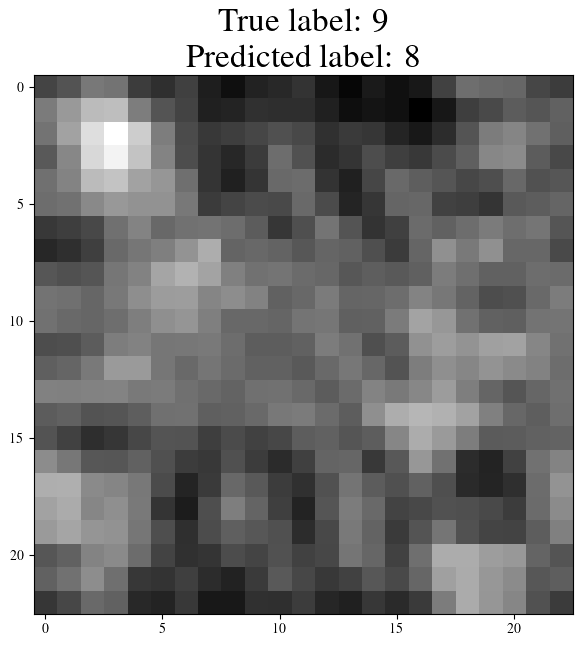

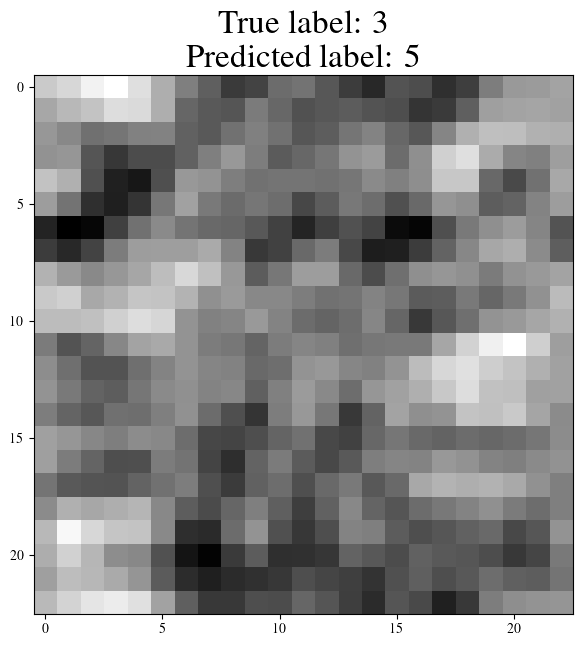

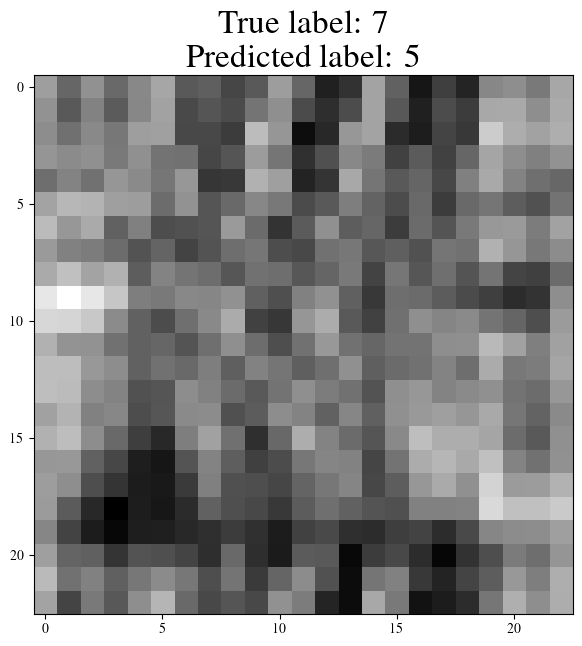

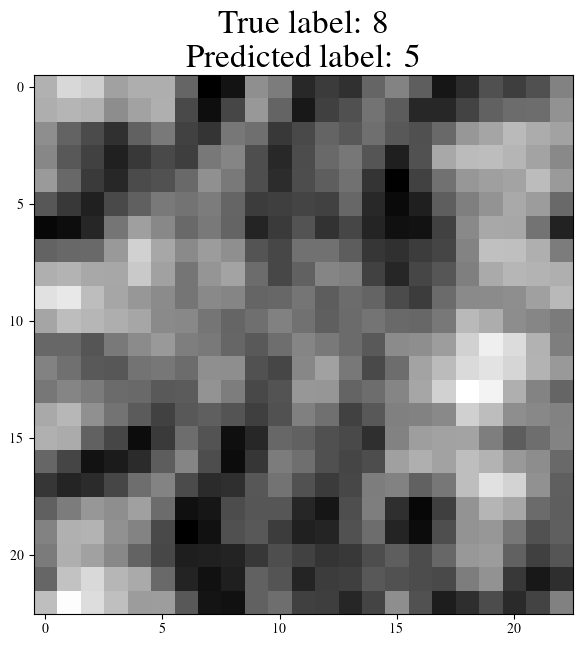

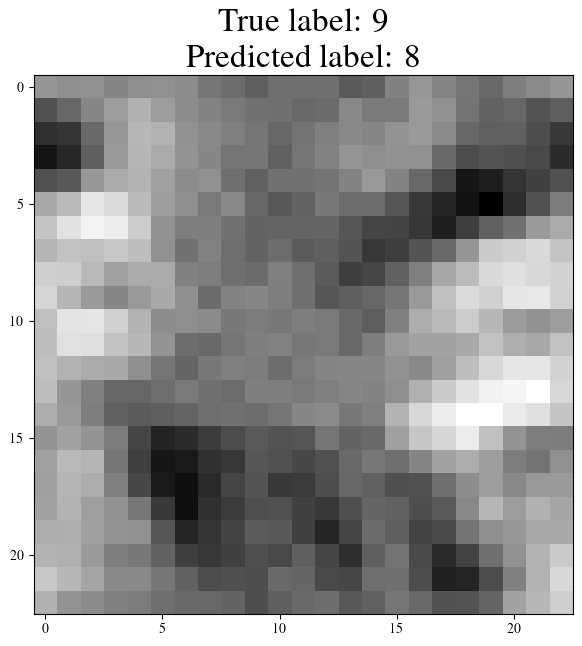

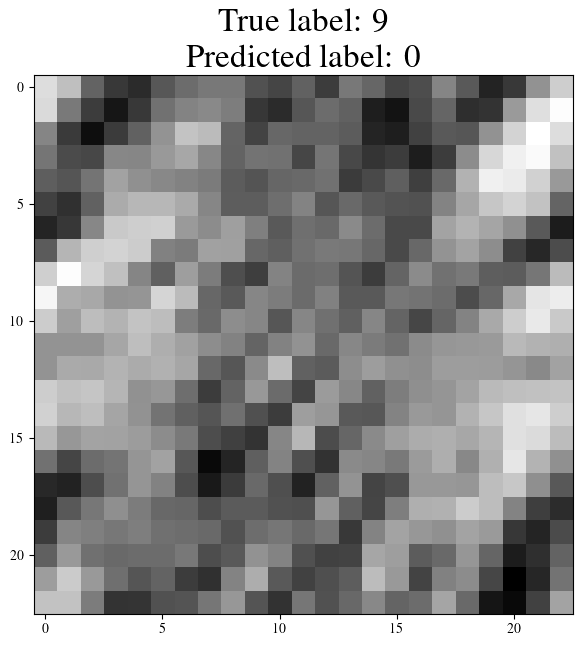

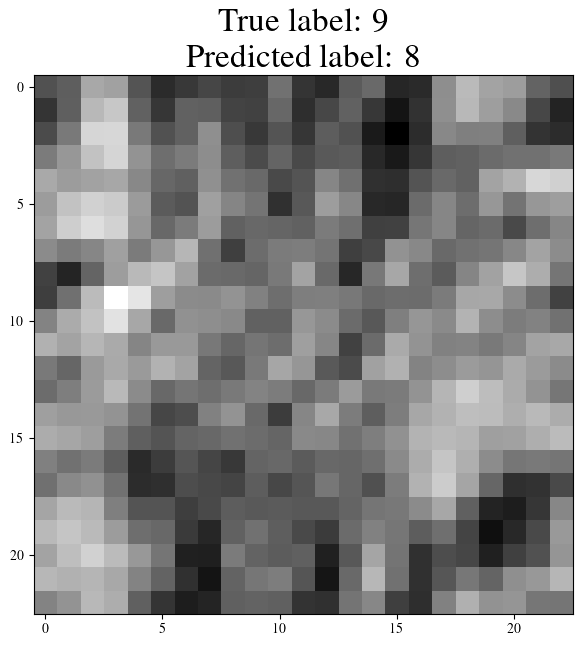

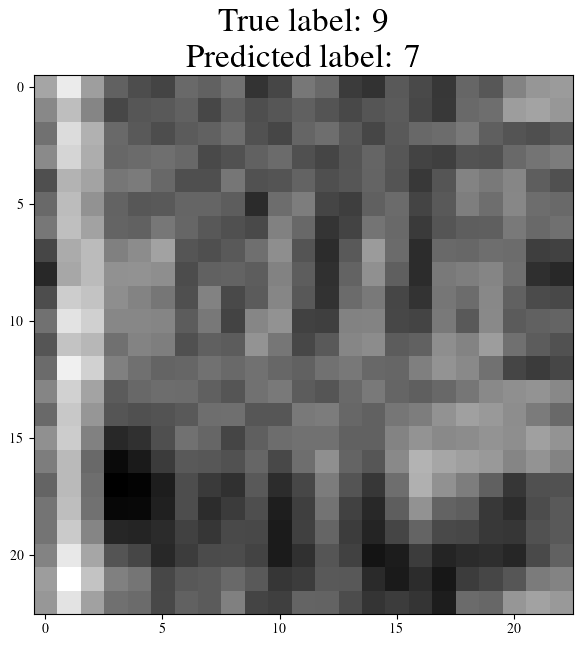

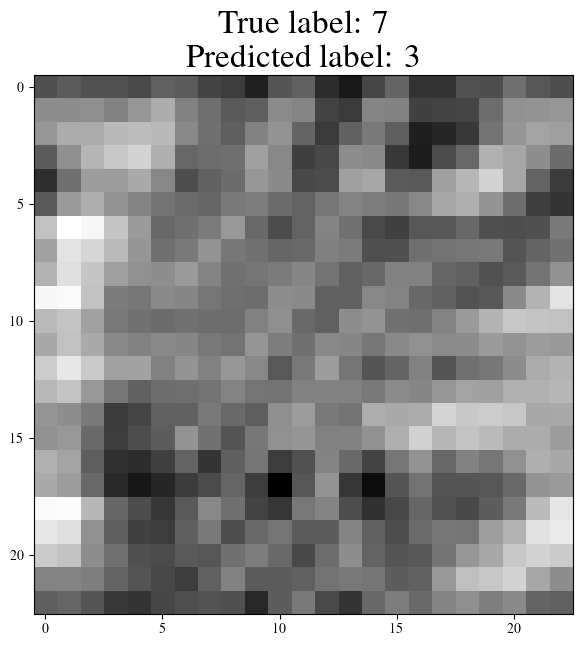

In [15]:
#index = 1
FIG_FOLDER = "/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/slides_coded_aperture/images/"

cmap = 'gray'
for index in range(30,50):#len(incorrect_examples)):
    img = np.squeeze(incorrect_examples[index][0])
    #true_img = mura.FFT_convolve(img, G)
    true_lab = incorrect_examples[index][1]
    pred_lab = incorrect_examples[index][2]

    if true_lab in [5,7,3,8,9]:
        #fig, axs = plt.subplots(2,1, figsize=(5,12))
        #axs = axs.ravel()
        fig, axs = plt.subplots(1,1, figsize=(7,7))
        #axs[0].imshow(true_img, cmap=cmap)
        axs.imshow(img, cmap=cmap)
        axs.set_title(f"True label: {true_lab}\nPredicted label: {pred_lab}", fontsize=24)
        #axs[0].set_title(f"Original Image", fontsize=24)
        #fig.savefig(FIG_FOLDER + f"misclass_encoded_{index}.png")
        plt.show() 

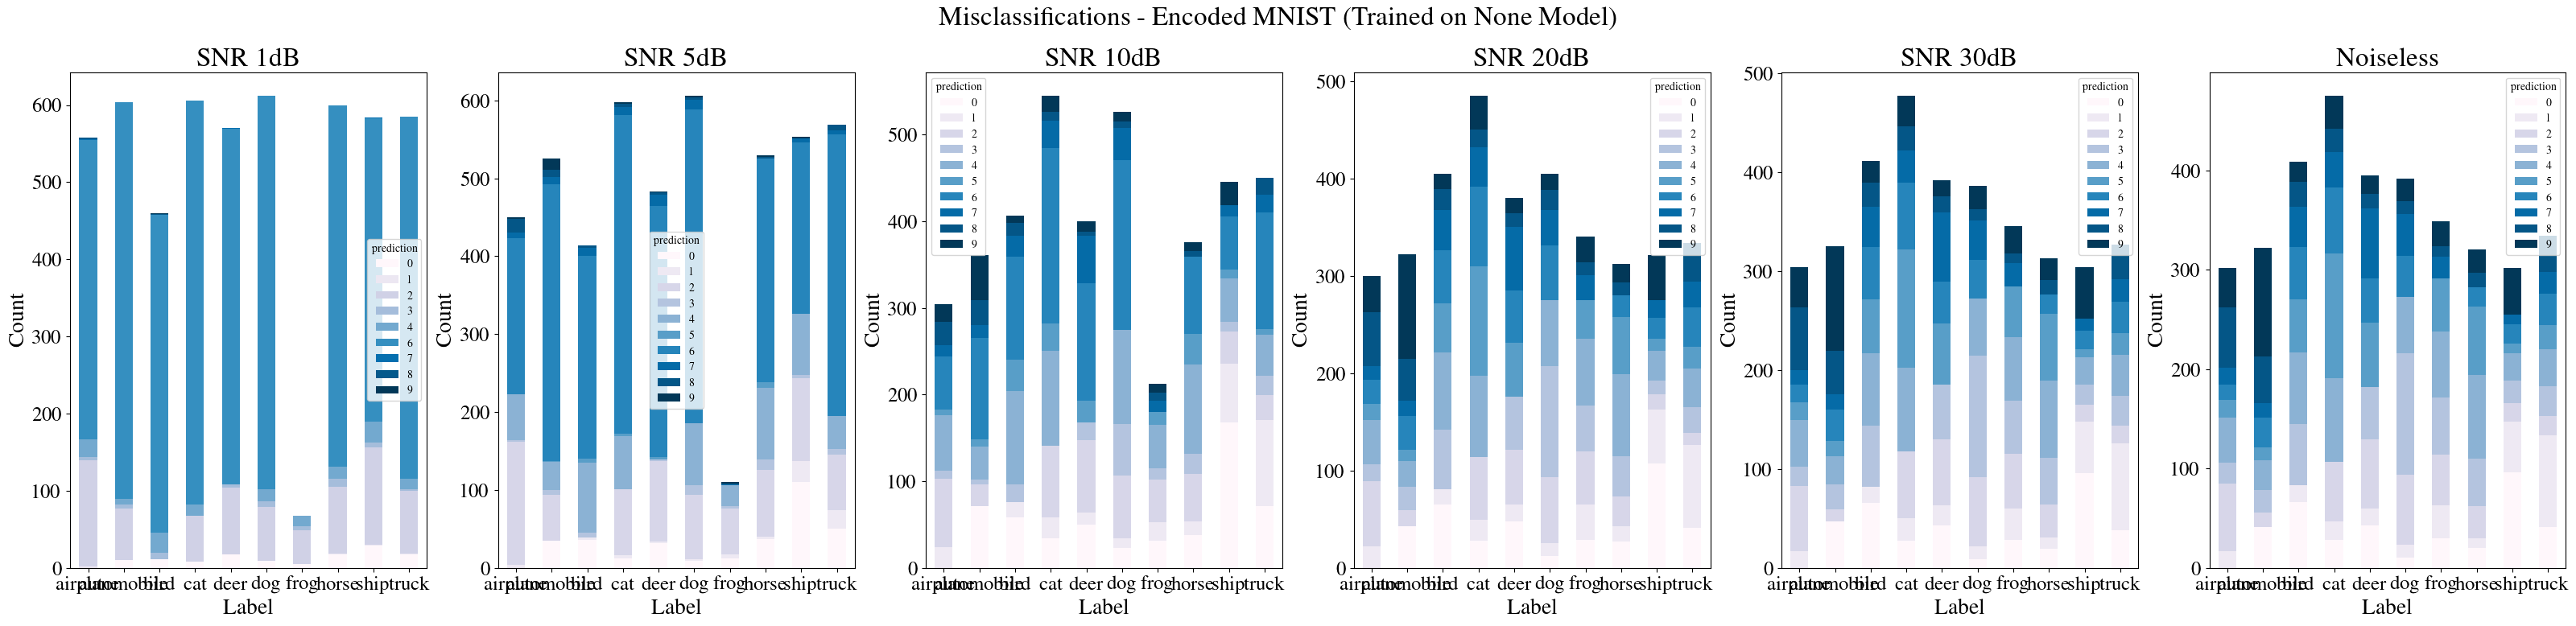

In [12]:
title_size = 24
tick_size  = 18
label_size = 20
# Get name of dataset for plot and determine classes
dataset = model.params['dataset'].split("_")[0] 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] if 'CIFAR10'.upper() in dataset else [i for i in range(10)]

fig, axs = plt.subplots(1,6, figsize=(40,8))
# Save dataframe with misclassifications
incorrect_examples = results[f'incorrect_examples_noiseless']
df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])


crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu", ax=axs[5], fontsize=tick_size)
axs[5].set_ylabel("Count", fontsize=label_size)
axs[5].set_xlabel("Label", fontsize=label_size)
axs[5].set_xticks(fontsize=tick_size, ticks=[i for i in range(len(classes))], labels=classes)
axs[5].set_title(f" Noiseless", fontsize=title_size)

for i, SNR in enumerate([1,5,10,20,30]):
    # Save dataframe with misclassifications
    incorrect_examples = results[f'incorrect_examples_{SNR}dB']
    df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])
    # print(f"{SNR}dB miclassified digits in order and percentage\n", df.label.value_counts(normalize=True))
    

    crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
    crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu", ax=axs[i], fontsize=tick_size)
    axs[i].set_ylabel("Count", fontsize=label_size)
    axs[i].set_xlabel("Label", fontsize=label_size)
    axs[i].set_xticks(fontsize=tick_size, ticks=[i for i in range(len(classes))], labels=classes)
    # axs[i].set_yticks(fontsize=tick_size)
    # axs[i].legend(fontsize=tick_size)
    axs[i].set_title(f" SNR {SNR}dB", fontsize=title_size)
    fig.suptitle(f"Misclassifications - Encoded MNIST (Trained on {model.params['SNR']} Model)", fontsize=title_size)
# fig.savefig(f"../figs/{model.params['kind']}/{model.params['method']}_method/misclassifications_counts_trained_{model.params['model']}_model.png")
plt.show()
    # print(crosstab_misclass)

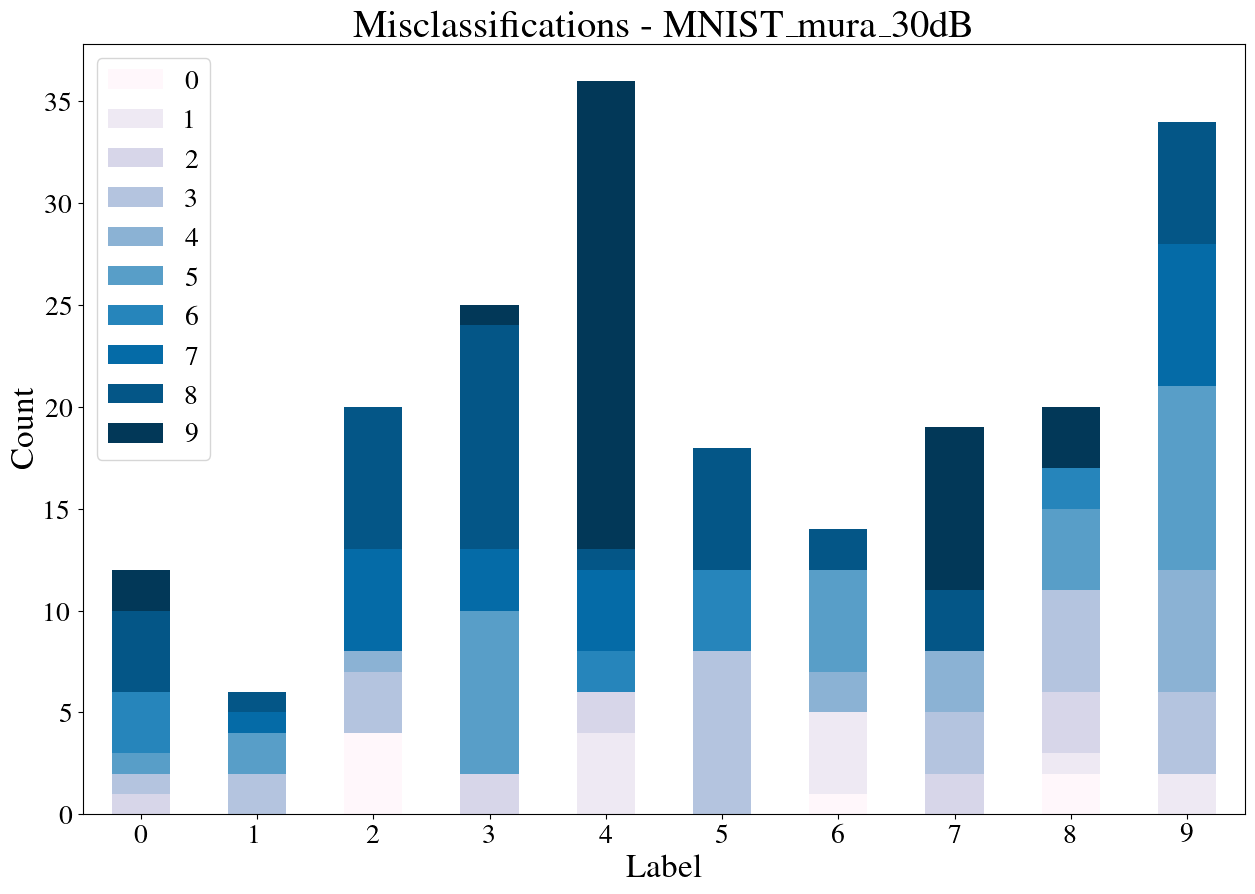

prediction  0  1  2  3  4  5  6  7   8   9
label                                     
0           0  0  1  1  0  1  3  0   4   2
1           0  0  0  2  0  2  0  1   1   0
2           4  0  0  3  1  0  0  5   7   0
3           0  0  2  0  0  8  0  3  11   1
4           0  4  2  0  0  0  2  4   1  23
5           0  0  0  8  0  0  4  0   6   0
6           1  4  0  0  2  5  0  0   2   0
7           0  0  2  3  3  0  0  0   3   8
8           2  1  3  5  0  4  2  0   0   3
9           0  2  0  4  6  9  0  7   6   0


In [11]:
title_size = 28
tick_size  = 20
label_size = 24

crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu")
plt.ylabel("Count", fontsize=label_size)
plt.xlabel("Label", fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.legend(fontsize=tick_size)
plt.title(f"Misclassifications - {params['dataset']}", fontsize=title_size)
#plt.savefig("../figs/misclassifications_counts_reconstructed_mnist.png")
plt.show()
print(crosstab_misclass)

# Other Plots

In [9]:
results_cifar = { "direct_noiseless": [40.30 , 40.28 , 39.53 , 27.72 , 15.38 , 11.93],  
            "direct_30dB"     :[40.35 , 40.18 , 39.53 , 31.93 , 18.35 ,12.73],
            "direct_20dB"     : [40.42 , 40.40 , 39.32 , 34.52 , 23.85 , 16.83],
            "direct_10dB"     : [37.97 , 38.03 , 38.28 , 36.55 , 33.33 , 26.37],
            "direct_5dB"      : [36.33 , 36.35 , 36.12 , 35.97 , 34.22 , 30.65],
            "direct_1dB"      : [33.25 , 33.55 , 33.20 , 33.07 , 33.05 , 31.75],
            "decoder_noiseless" :  [55.78 , 55.37 , 53.88  , 36.18  , 17.48  ,11.65],
            "decoder_30dB"      :  [52.48 , 52.53 , 50.47  , 32.67  , 18.43 ,12.87 ],
            "decoder_20dB"      :  [50.72 , 50.80 , 50.48  , 43.92  , 28.37  ,16.97 ],
            "decoder_10dB"      :  [50.25 , 50.42 , 50.58  , 48.78  , 38.85 , 21.77 ],
            "decoder_5dB"       :  [44.00 , 44.28 , 44.38  , 43.25  ,40.98  , 35.52],
            "decoder_1dB"       :  [40.38 , 40.75 , 41.02  , 40.17  , 38.67  ,34.87 ],
}

In [11]:
df_cifar = pd.DataFrame.from_dict(results_cifar)

In [12]:
import plotly.graph_objects as go

noise_levels = ["Noiseless", "10dB", "5dB", "1dB"]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=noise_levels,
    y=[20, 14, 25, 16, 18, 22, 19, 15, 12, 16, 14, 17],
    name='Primary Product',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=months,
    y=[19, 14, 22, 14, 16, 19, 15, 14, 10, 12, 12, 16],
    name='Secondary Product',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

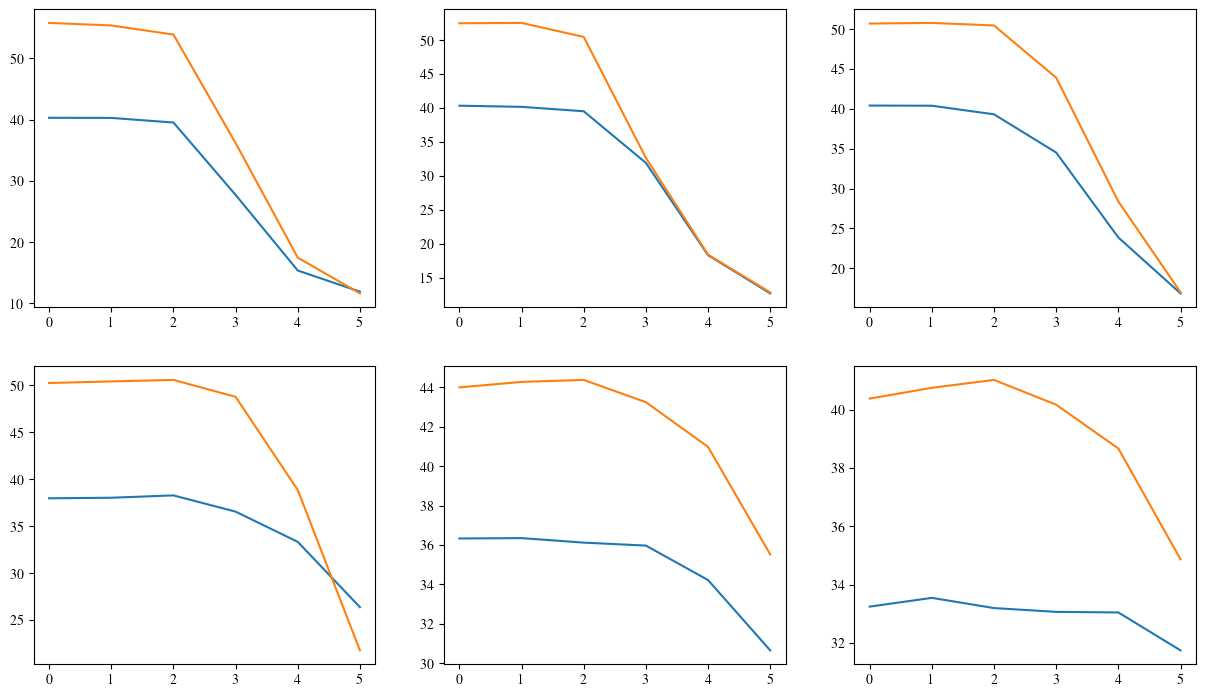

In [44]:
x_axis = range(6)

fig, axs = plt.subplots(2,3)
axs = axs.ravel()
for i, noise in enumerate(['noiseless', '30dB', '20dB', '10dB', '5dB', '1dB']):
    axs[i].plot(x_axis, results[f'direct_{noise}'])
    axs[i].plot(x_axis, results[f'decoder_{noise}'])
plt.show()